In [18]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.applications import EfficientNetB3, MobileNetV2, EfficientNetB7, NASNetLarge, InceptionV3
from sklearn.model_selection import train_test_split 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import keras_tuner
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

## Uploading pictures

I create a function that will go into the folder and return images and their label in a tuple form

In [2]:
def load_images_from_folder(folder_path):
    images = []
    labels = []
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        for image_name in os.listdir(label_path):
            img_path = os.path.join(label_path, image_name)
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize((128, 128))
                img = np.array(img)
                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    return np.array(images), np.array(labels)

I assign train group images and labels with the function.

In [3]:
train_images, train_labels = load_images_from_folder("data/Train")

In [4]:
train_images.shape

(2513, 128, 128, 3)

Some examples of a trainset data with labels.

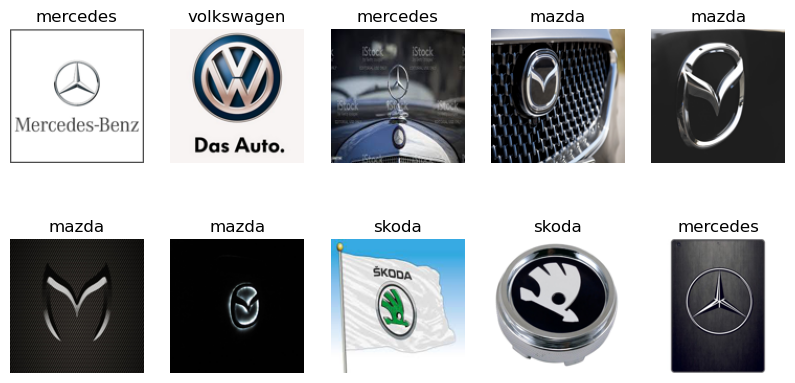

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i in range(10):
    random_number = random.randint(1, train_images.shape[0])
    row = i // 5
    col = i % 5
    axes[row, col].imshow(train_images[random_number])
    axes[row, col].set_title(train_labels[random_number])
    axes[row, col].axis('off')

I assign test group images and labels with the function.

In [6]:
test_images, test_labels = load_images_from_folder('data/Test')

In [7]:
test_images.shape

(400, 128, 128, 3)

Some examples of a testset data with labels.

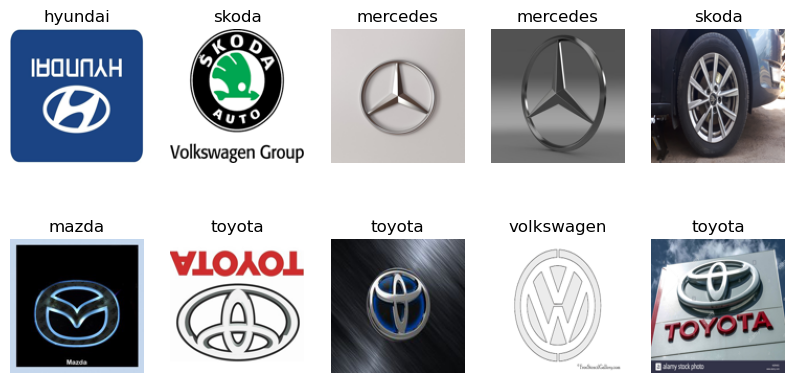

In [8]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i in range(10):
    random_number = random.randint(1, test_images.shape[0])
    row = i // 5
    col = i % 5
    axes[row, col].imshow(test_images[random_number])
    axes[row, col].set_title(test_labels[random_number])
    axes[row, col].axis('off')

## Data preparing

I perform label encoding and then one-hot encoding on the target set (labels), so my machine learning models can work on it.

In [9]:
train_labels

array(['hyundai', 'hyundai', 'hyundai', ..., 'opel', 'opel', 'opel'],
      dtype='<U10')

In [10]:
def transform_target(some_set):
    label_encoder = LabelEncoder()
    train_y = label_encoder.fit_transform(some_set)
    train_y = to_categorical(train_y)
    return train_y

In [11]:
train_val_y = transform_target(train_labels)
test_y = transform_target(test_labels)

In [12]:
train_val_y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

I scale train and test datasets, so they are in range 0-1 for better results.

In [13]:
train_val_x = train_images / 255

test_x = test_images / 255

In [14]:
train_val_x[50]

array([[[0.96078431, 0.49019608, 0.39607843],
        [0.95686275, 0.48627451, 0.39215686],
        [0.95686275, 0.48627451, 0.39215686],
        ...,
        [0.92156863, 0.59215686, 0.52941176],
        [0.91764706, 0.59215686, 0.52941176],
        [0.91764706, 0.59215686, 0.52941176]],

       [[0.96078431, 0.49019608, 0.39607843],
        [0.95686275, 0.48627451, 0.39215686],
        [0.95686275, 0.48627451, 0.39215686],
        ...,
        [0.92156863, 0.59215686, 0.52941176],
        [0.91764706, 0.59215686, 0.52941176],
        [0.91764706, 0.59215686, 0.52941176]],

       [[0.96078431, 0.49019608, 0.39607843],
        [0.95686275, 0.48627451, 0.39215686],
        [0.95686275, 0.48627451, 0.39215686],
        ...,
        [0.92156863, 0.59215686, 0.5254902 ],
        [0.91764706, 0.59215686, 0.52941176],
        [0.91764706, 0.59215686, 0.52941176]],

       ...,

       [[0.77647059, 0.77647059, 0.77647059],
        [1.        , 1.        , 1.        ],
        [0.99607843, 0

I separate validation data from training data, so I can later test models efficiency on data that they were not trained on.

In [15]:
train_x, val_x, train_y, val_y = train_test_split(train_val_x, train_val_y, test_size=0.2, stratify=train_val_y, random_state=42)

## Model selection

I chose 3 types of architectures to perform tests on: EfficientNetB3,InceptionV3, MobileNetV2.
* EfficientNetB3 - Highest Accuracy (81.6%), very slow (140 ms per inference step)
* InceptionV3 - Medium Accuracy (77.9%), medium speed (42.2 ms per inference step)
* MobileNetv2 - Lowest Accuracy (71.3%), fastest (25.9 ms per inference step)

I'm going to quickly check if the model work on a set hyperparameters. I will then choose the best model and tune its hyperparameters.

In [16]:
def model_checker(base_model):
        
    model = base_model.output
    model = GlobalAveragePooling2D()(model)
#     model = BatchNormalization()(model)
    model = Dropout(0.5)(model)
    model = Dense(1024, activation='relu')(model)
#     model = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(model)
#     model = BatchNormalization()(model)
    model = Dropout(0.5)(model)
    predictions = Dense(8, activation='softmax')(model)

    final_model = Model(inputs=base_model.input, outputs=predictions)

    final_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    
    history = final_model.fit(
    train_x,
    train_y,
    epochs=10,
    batch_size=64,
    validation_data=(val_x, val_y),
#     callbacks=[early_stopping],
    verbose=1
    )
    
    return final_model, history
    

#### EfficientNetB3

In [36]:
en3_model, en3_history = model_checker(EfficientNetB3(include_top=False, weights="imagenet", input_shape=(128, 128, 3)))

Epoch 1/10


KeyboardInterrupt: 

EfficientNetB3 can not be used in this excercise. Its val_accuracy stays on 0.1250 with any hyperparameters configuration I tried. I'm going to try EfficientNetB7.

#### EfficientNetB7

In [ ]:
en7_model, en7_history = model_checker(EfficientNetB7(include_top=False, weights="imagenet", input_shape=(128, 128, 3)))

As efficient nets are not working with this dataset I choose NASNetLarge in its place.

#### NASNetLarge

In [ ]:
nnl_model, nnl_history = model_checker(NASNetLarge(include_top=False, weights="imagenet", input_shape=(128, 128, 3)))

#### MobileNetV2

In [46]:
mn_model, mn_history = model_checker(MobileNetV2(include_top=False, weights="imagenet", input_shape=(128, 128, 3)))

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.1687 - loss: 4.1877 - val_accuracy: 0.4215 - val_loss: 2.8224
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.4967 - loss: 2.7641 - val_accuracy: 0.5070 - val_loss: 2.5924
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.6521 - loss: 2.1816 - val_accuracy: 0.5865 - val_loss: 2.3809
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.7445 - loss: 1.9073 - val_accuracy: 0.6203 - val_loss: 2.3199
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.8255 - loss: 1.6363 - val_accuracy: 0.6839 - val_loss: 2.2132
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.8608 - loss: 1.5438 - val_accuracy: 0.6779 - val_loss: 2.1786
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.9101 - loss: 1.4095 - val_accuracy: 0.7356 - val_loss: 2.0394
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.9204 - loss: 1.3562 - val_accuracy: 0.7396 - val_loss:

#### InceptionV3

In [19]:
mn_model, mn_history = model_checker(InceptionV3(include_top=False, weights="imagenet", input_shape=(128, 128, 3)))

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.1690 - loss: 2.3813 - val_accuracy: 0.2624 - val_loss: 2.3897
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - accuracy: 0.3049 - loss: 1.8956 - val_accuracy: 0.3936 - val_loss: 2.1909
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step - accuracy: 0.5545 - loss: 1.3111 - val_accuracy: 0.5805 - val_loss: 1.3548
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 112s 4s/step - accuracy: 0.7104 - loss: 0.8960 - val_accuracy: 0.6759 - val_loss: 1.0843
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step - accuracy: 0.8156 - loss: 0.5659 - val_accuracy: 0.7296 - val_loss: 0.8230
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step - accuracy: 0.8880 - loss: 0.3757 - val_accuracy: 0.7873 - val_loss: 0.7215
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step - accuracy: 0.9368 - loss: 0.2240 - val_accuracy: 0.7893 - val_loss: 0.7424
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step - accurac

## Data Augmentation

I'm going to check on a fast model (mobileNetV2) if data augmentation improves results of the model.